# NEURAL NETWORK ON EMNIST DATASET

I am Rishabh Jain and this my neural network on EMNIST dataset (balanced)

###STEP 1: Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle


###STEP 2: Get the data, processing it and loading it

In [68]:
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader,random_split

# Directly getting data from torchvision module instead of manually getting it
root="data"
transform = transforms.Compose([

    transforms.ToTensor()
])
traindata = EMNIST(root=root,split="balanced",train=True,download=True,transform=transform)
testdata = EMNIST(root=root,split="balanced",train=False,download=True,transform=transform)

# Splitting into train and dev set
trainsize = int(0.9 * len(traindata))
devsize = len(traindata) - trainsize
train_data, dev_data = random_split(traindata, [trainsize, devsize])

#Loading all the three loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=128, shuffle=False)
test_loader = DataLoader(testdata, batch_size=128, shuffle=False)

###STEP 3: Making the model

In [69]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784,16)
        self.left1 = nn.Linear(16,8)
        self.left2 = nn.Linear(8,8)
        self.right1 = nn.Linear(16,12)
        self.right2 = nn.Linear(12,8)
        self.out = nn.Linear(16,47)

    def forward(self,x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        l1 = F.relu(self.left1(x))
        l2 = F.relu(self.left2(l1))
        l = l1 + l2

        r1 = F.relu(self.right1(x))
        r = F.relu(self.right2(r1))

        x = torch.cat((l,r),1)
        return self.out(x)


###STEP 4: Setting the optimizer and the loss function

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net().to(device)

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, nesterov = True, weight_decay=0.0001)
lossfn = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


###STEP 5: Main code of the model training

In [71]:
def train(model, device, train_loader, dev_loader, lossfn, optimizer, num_epochs):
    train_losses, dev_losses = [], []
    train_accs, dev_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        trainloss = 0.0
        traincorrect = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossfn(outputs, labels)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            traincorrect += (predicted == labels).sum().item()

        avgtrainloss = trainloss / trainsize
        trainacc = traincorrect / trainsize
        train_losses.append(avgtrainloss)
        train_accs.append(trainacc)

        model.eval()
        devloss = 0.0
        devcorrect = 0

        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = lossfn(outputs, labels)
                devloss += loss.item()*inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                devcorrect += (predicted == labels).sum().item()

        avgdevloss = devloss / devsize
        devacc = devcorrect / devsize
        dev_losses.append(avgdevloss)
        dev_accs.append(devacc)


        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avgtrainloss:.4f} , Train Acc: {trainacc:.4f} , Dev Loss: {avgdevloss:.4f} , Dev Acc: {devacc:.4f}")

    return train_losses, train_accs, dev_losses, dev_accs

###STEP 6: Training the model and saving the weights

In [74]:
train_losses, train_accs, dev_losses, dev_accs = train(model,device,train_loader,dev_loader,lossfn,optimizer,num_epochs=5)
with open("emnist_model.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)

Epoch 1/5 - Train Loss: 0.7340 , Train Acc: 0.7720 , Dev Loss: 0.8159 , Dev Acc: 0.7554
Epoch 2/5 - Train Loss: 0.7306 , Train Acc: 0.7722 , Dev Loss: 0.8137 , Dev Acc: 0.7566
Epoch 3/5 - Train Loss: 0.7305 , Train Acc: 0.7727 , Dev Loss: 0.8131 , Dev Acc: 0.7566
Epoch 4/5 - Train Loss: 0.7305 , Train Acc: 0.7730 , Dev Loss: 0.8142 , Dev Acc: 0.7575
Epoch 5/5 - Train Loss: 0.7304 , Train Acc: 0.7733 , Dev Loss: 0.8136 , Dev Acc: 0.7562


###STEP 7: Testing the model and saving predictions in submissions.csv

In [ ]:
def testmodel(model, testloader, device):
    model.eval()
    preds = []
    indices = []

    with torch.no_grad():
        for batch_id, (inputs, _) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            indices.extend(range(batch_id * testloader.batch_size, batch_id * testloader.batch_size + inputs.size(0)))

    df = pd.DataFrame({'Id': indices,'Predicted': preds})
    df.to_csv("submissions.csv", index=False)

testmodel(model,test_loader,device)


###STEP 8: Plotting train and dev losses and accuracy plots

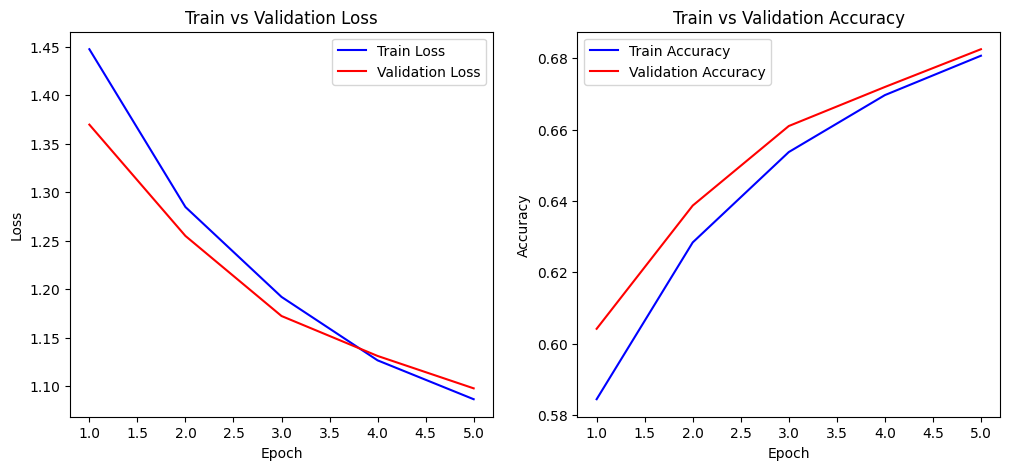

In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    plt.show()

plot_training_history(train_losses, dev_losses, train_accs, dev_accs)